In [ ]:
# Прошу прощения, пока не сделано. Решение будет в течении суток.

In [ ]:
Элементарные алгоритмы обработки временных рядов
Преподаватель: Алексей Кузьмин

Взять ряд из первого задания (в двух вариантах - стационарный и нет) 
и приблизить оба эти варианта моделями из класса MA. Оценить качество и 
прислать соображения в почему была выбрана та или иная модель. 
(задание оформить в jupyter-notebook)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [15]:
registration = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=";")
dowjones = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [60]:
def tsplot(arr_y, lags=None, figsize=(18, 8), style='bmh'):
    """
        arr_y - массив из пар последовательностей 
    """
    m = (len(arr_y) // 3) + (1 if len(arr_y) % 3 < 0 else 0)
    fig, axes = plt.subplots(m, 3, figsize=figsize)
    with plt.style.context(style):
        for i in range(len(arr_y)):
            x,y = i // 3, i % 3
            cur_ax = axes[y] if m < 2 else  axes[x,y]
            pd.Series(arr_y[i][0]).plot(ax=cur_ax, color='blue', label='Or')
            pd.Series(arr_y[i][1]).plot(ax=cur_ax, color='red', label='Or')
        plt.show()
    return    

In [61]:
# получим из исходных рядов стационарные ряды

registration_raw = registration['registration']
dowjones_raw = dowjones['DowJones']

registration_bc = boxcox(registration_raw, 0)
registration_bc_d = registration_bc[1:] - registration_bc[:-1]
registration_stat = registration_bc_d[12:] - registration_bc_d[:-12]

# Разделим ряд dowjones_raw на 2 части

dowjones_raw_1 = list(dowjones_raw[:80])
dowjones_raw_2 = list(dowjones_raw[80:])

dowjones_stat_1 = np.diff(dowjones_raw_1, 1)

dowjones_2_bc = boxcox(dowjones_raw_2, -0.5)
dowjones_stat_2 = dowjones_2_bc[1:] -  dowjones_2_bc[:-1]

In [62]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

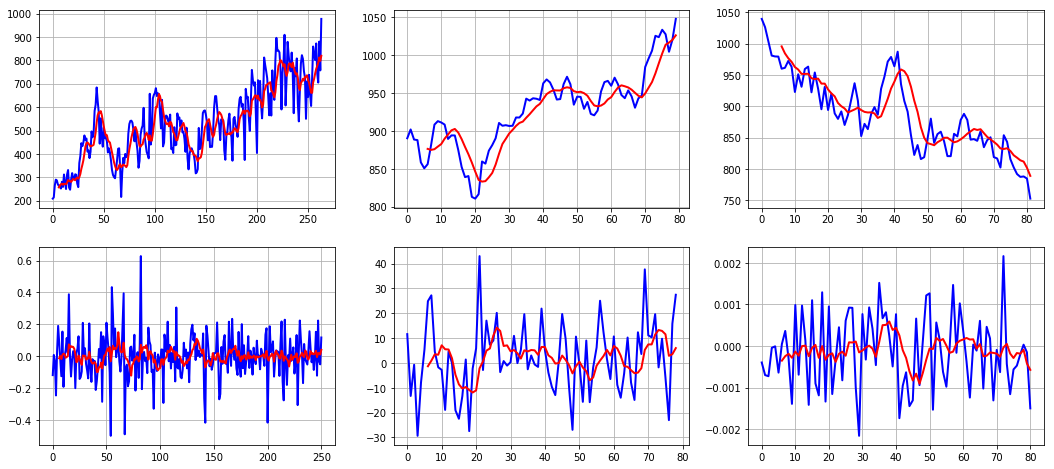

In [64]:
registration_ma_raw = moving_average(registration_raw, 7)
registration_ma_stat = moving_average(registration_stat, 7)

dowjones_ma_1_raw = moving_average(dowjones_raw_1, 7)
dowjones_ma_1_stat = moving_average(dowjones_stat_1, 7)

dowjones_ma_2_raw = moving_average(dowjones_raw_2, 7)
dowjones_ma_2_stat = moving_average(dowjones_stat_2, 7)

tsplot([[registration_raw,registration_ma_raw],
        [dowjones_raw_1,dowjones_ma_1_raw],
        [dowjones_raw_2,dowjones_ma_2_raw],
        [registration_stat,registration_ma_stat],
        [dowjones_stat_1,dowjones_ma_1_stat],
        [dowjones_stat_2,dowjones_ma_2_stat]])

In [65]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

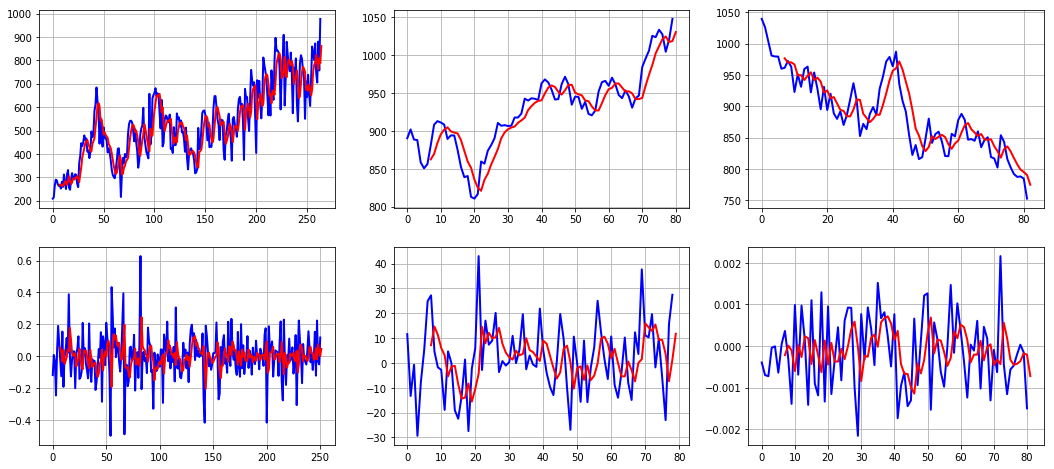

In [67]:
registration_wma_raw = weighted_moving_average(registration_raw,  7, [1,1,2,3,5,8,13])
registration_wma_stat = weighted_moving_average(registration_stat,  7, [1,1,2,3,5,8,13])

dowjones_wma_1_raw = weighted_moving_average(dowjones_raw_1,  7, [1,1,2,3,5,8,13])
dowjones_wma_1_stat = weighted_moving_average(dowjones_stat_1,  7, [1,1,2,3,5,8,13])

dowjones_wma_2_raw = weighted_moving_average(dowjones_raw_2,  7, [1,1,2,3,5,8,13])
dowjones_wma_2_stat = weighted_moving_average(dowjones_stat_2,  7, [1,1,2,3,5,8,13])

tsplot([[registration_raw,registration_wma_raw],
        [dowjones_raw_1,dowjones_wma_1_raw],
        [dowjones_raw_2,dowjones_wma_2_raw],
        [registration_stat,registration_wma_stat],
        [dowjones_stat_1,dowjones_wma_1_stat],
        [dowjones_stat_2,dowjones_wma_2_stat]])

In [69]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

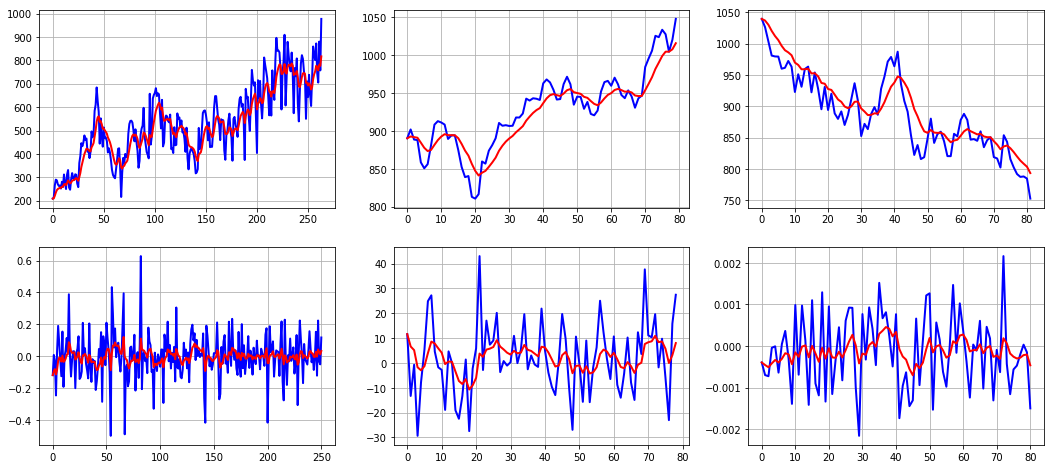

In [70]:
registration_ema_raw = exponential_moving_average(registration_raw, 0.2)
registration_ema_stat = exponential_moving_average(registration_stat, 0.2)

dowjones_ema_1_raw = exponential_moving_average(dowjones_raw_1, 0.2)
dowjones_ema_1_stat = exponential_moving_average(dowjones_stat_1, 0.2)

dowjones_ema_2_raw = exponential_moving_average(dowjones_raw_2, 0.2)
dowjones_ema_2_stat = exponential_moving_average(dowjones_stat_2, 0.2)

tsplot([[registration_raw,registration_ema_raw],
        [dowjones_raw_1,dowjones_ema_1_raw],
        [dowjones_raw_2,dowjones_ema_2_raw],
        [registration_stat,registration_ema_stat],
        [dowjones_stat_1,dowjones_ema_1_stat],
        [dowjones_stat_2,dowjones_ema_2_stat]])

In [76]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

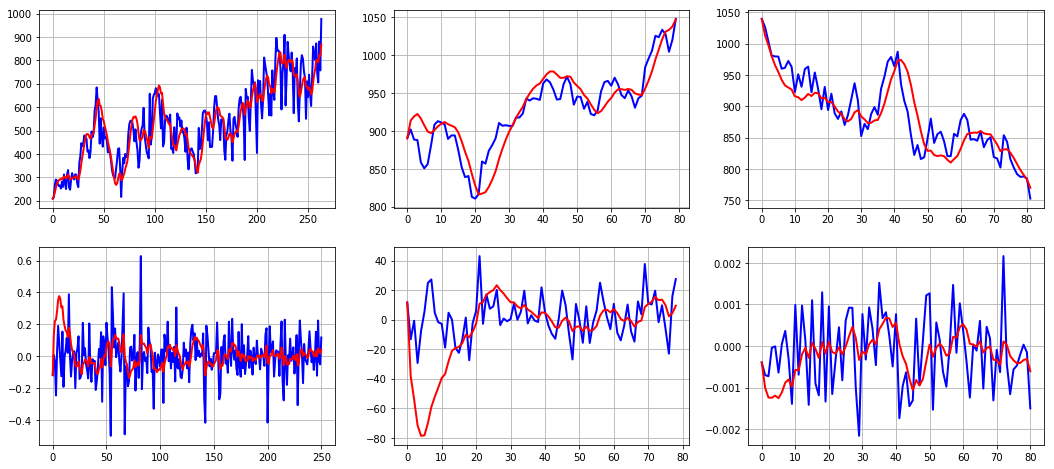

In [77]:
registration_dema_raw = double_ema(registration_raw, 0.2, 0.2)
registration_dema_stat = double_ema(registration_stat, 0.2, 0.2)

dowjones_dema_1_raw = double_ema(dowjones_raw_1, 0.2, 0.2)
dowjones_dema_1_stat = double_ema(dowjones_stat_1, 0.2, 0.2)

dowjones_dema_2_raw = double_ema(dowjones_raw_2, 0.2, 0.2)
dowjones_dema_2_stat = double_ema(dowjones_stat_2, 0.2, 0.2)

tsplot([[registration_raw,registration_dema_raw],
        [dowjones_raw_1,dowjones_dema_1_raw],
        [dowjones_raw_2,dowjones_dema_2_raw],
        [registration_stat,registration_dema_stat],
        [dowjones_stat_1,dowjones_dema_1_stat],
        [dowjones_stat_2,dowjones_dema_2_stat]])

In [ ]:
def mse2_cross_val(X):
    
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))


train, test, val = series[:60], series[60:70], series[70:]

opt = minimize(mse2, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

alpha_opt, beta_opt = opt.x

plot_tema(alpha_opt, beta_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))